# Analyzing House Prices & Venues in Atlanta

Scroll down to the bottom for the results.

Note: The map does not show on Github, but you can click [here](https://nbviewer.jupyter.org/github/jakesiu/Analyzing-House-Prices-and-Venues-in-Atlanta/blob/master/Analyzing%20House%20Prices%20and%20Venues%20in%20Atlanta.ipynb) to view the entire file with the interactive map.


### Importing Libraries:

In [573]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim #conda install -c conda-forge geopy --yes
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import folium
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder

import os
import glob

## Segmenting and Clustering Counties:

### Web Scraping Zip Codes and County:

In [320]:
# This site did not cover all of the zip codes. Will use this as a future reference though when scraping random sites

#req = requests.get("https://worldpostalcode.com/united-states/georgia/atlanta")
#soup = BeautifulSoup(req.content,'lxml')
#
#i = []
#for i in soup.find_all('div', class_="code"):
#    for match in soup.findAll('span'):
#        match.unwrap()
#
#df = pd.DataFrame(i).replace(' ', np.nan).dropna().rename(columns={0:'Zip Code'}).astype(str).astype(int).reset_index(drop=True)

#j = pd.DataFrame()
#for i in df['Zip Code']:
#    req = requests.get('https://www.getzips.com/cgi-bin/ziplook.exe?What=1&Zip=' + str(i) + '&Submit=Look+It+Up')
#    soup = BeautifulSoup(req.content,'lxml')
#    table = soup.find_all('table')[2]
#    df1 = pd.read_html(str(table))
#    df1 = pd.DataFrame(df1[0]).drop([0,])
#    j = j.append(df1)
#
#j = j.reset_index(drop=True).drop(columns=[1, 3]).rename(columns={0: "ZipCode", 2: "County"})



In [321]:
req = requests.get("https://namecensus.com/igapo/zip_codes/metropolitan-areas/metro-alpha/Atlanta%20(GA)1.html")
soup = BeautifulSoup(req.content,'lxml')

i = []
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
zipcodes = pd.DataFrame(df[0])
zipcodes = zipcodes.drop([1, 3, 4, 5], axis=1)
zipcodes[0] = zipcodes[0].str[:5]
zipcodes[2] = zipcodes[2].map(lambda x: x.rstrip('County').strip())
zipcodes.columns = ['ZipCode', 'County']
zipcodes

ZipCode    County
0     30101      Cobb
1     30102  Cherokee
2     30103    Bartow
3     30320    Fulton
4     30004    Fulton
..      ...       ...
508   30187   Douglas
509   30360    DeKalb
510   30188  Cherokee
511   30189  Cherokee
512   30214   Fayette

[513 rows x 2 columns]

### Merging Postal Codes with Coordinates:

In [322]:
#https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/
coordinates = pd.read_csv('us-zip-code-latitude-and-longitude.csv',sep = ';')
zipcodes['ZipCode'] = zipcodes['ZipCode'].astype(int) 
zipcodes = pd.merge(zipcodes, coordinates, on ='ZipCode', how ='inner').drop(['Timezone', 'Daylight savings time flag', 'geopoint'], axis=1)
zipcodes = zipcodes.dropna().drop_duplicates().drop_duplicates(subset=["ZipCode"], keep="last").reset_index(drop=True)
zipcodes = zipcodes.loc[zipcodes['County'].isin(['Cherokee','Fulton', 'DeKalb', 'Gwinnett', 'Cobb', 'Clayton', 'Douglas', 'Fayette', 'Henry', 'Rockdale'])]
df2 = zipcodes

In [323]:
df2.style.hide_index()

### Plotting Neighborhoods on the map

In [324]:
address = 'Atlanta, GA'

geolocator = Nominatim(user_agent="Atlanta, Georgia")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Atlanta, Georgia are {}, {}.'.format(latitude, longitude))

# create map of ATL using latitude and longitude values
map_atlanta = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, zipcode, county, in zip(df2['Latitude'], df2['Longitude'], df2['ZipCode'], df2['County']):
    label = '{}, {} County'.format(zipcode, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atlanta)  
    
map_atlanta

The geograpical coordinate of Atlanta, Georgia are 33.7490987, -84.3901849.


### Exploring Venues in the City

In [325]:
CLIENT_ID = 'B5MCPOC110OPRRF1HAWVLGQ4GWKKAMVYFHQLOUCDOKBVX1ZR' # my Foursquare ID
CLIENT_SECRET = 'JX4LIGIKQBNOO4F0CK3QIFPGRIRVDKINLZGRONE0MPPRR2PX' # my Foursquare Secret
VERSION = '20200605'

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

df2.loc[0, 'ZipCode']

neighborhood_latitude = df2.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df2.loc[0, 'Longitude'] # neighborhood longitude value

zipcode_name = df2.loc[0, 'ZipCode'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(zipcode_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

LIMIT = 100 # limit of number of venues returned by the FourSquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

My credentails:
CLIENT_ID: B5MCPOC110OPRRF1HAWVLGQ4GWKKAMVYFHQLOUCDOKBVX1ZR
CLIENT_SECRET:JX4LIGIKQBNOO4F0CK3QIFPGRIRVDKINLZGRONE0MPPRR2PX
Latitude and longitude values of 30101 are 34.052285, -84.68483.


In [326]:
results = requests.get(url).json()

In [327]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [328]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                              'ZipCode Latitude', 
                              'ZipCode Longitude', 
                              'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [329]:
city_venues = getNearbyVenues(names=df2['ZipCode'],
                                   latitudes=df2['Latitude'],
                                   longitudes=df2['Longitude'])

30101
30102
30320
30004
30005
30009
30022
30023
30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30321
30322
30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30364
30366
30368
30369
30370
30371
30374
30375
30376
30377
30378
30379
30380
30384
30385
30388
30390
30392
30394
30396
30398
31106
31107
31119
31126
31131
31139
31141
31145
31146
31150
31156
31192
31193
31195
31196
30363
39901
30060
30106
30168
30002
30107
30144
30032
30092
30096
30205
30515
30518
30519
30114
30115
30039
30268
30111
30021
30288
30012
30013
30094
30019
30030
30031
30033
30034
30035
30036
30037
30069
30133
30134
30135
30154
30026
30029
30095
30097
30098
30099
30294
30213
30214
30215
30298
30297
30017
30228
30142
30188
30024
30236
30237
30238
30152
30183
30260
30042
30043
30044
30045
3004

In [330]:
city_venues.to_csv("city_venues_foursquareapi.csv", index=False)

In [331]:
print(city_venues.shape)
print('There are {} unique categories.'.format(len(city_venues['Venue Category'].unique())))
city_venues = city_venues.dropna().drop_duplicates()
city_venues = city_venues.drop_duplicates(subset=["ZipCode Latitude","ZipCode Longitude", "Venue"], keep="last")

(1195, 7)
There are 241 unique categories.


In [332]:
city_venues = pd.merge(city_venues, df2, on ='ZipCode', how ='inner')
city_venues

ZipCode  ZipCode Latitude  ZipCode Longitude  \
0       30101         34.052285          -84.68483   
1       30102         34.097998          -84.61830   
2       30102         34.097998          -84.61830   
3       30102         34.097998          -84.61830   
4       30102         34.097998          -84.61830   
...       ...               ...                ...   
1042    30290         33.480120          -84.58724   
1043    30187         33.670405          -84.83809   
1044    30189         34.117565          -84.57176   
1045    30189         34.117565          -84.57176   
1046    30189         34.117565          -84.57176   

                                    Venue  Venue Latitude  Venue Longitude  \
0      Kroger Grocery Pickup and Delivery       34.056140       -84.684272   
1                     Brand New Basements       34.096560       -84.618960   
2               Rabbit Hole to Onederland       34.096345       -84.618785   
3                         Ridge Mill Pool       34.098150       -84.618953   
4              ResCon Chandler Group, LLC       34.099962       -84.614312   
...                                   ...             ...              ...   
1042                      Real Life Store       33.479511       -84.591301   
1043        Wicker's Opulent Hair &Beauty       33.672980       -84.840470   
1044  Wellsley @ Towne Lake Tennis Courts       34.114604       -84.570135   
1045                            Wellesley       34.113770       -84.574296   
1046                          Doggie Walk       34.119104       -84.576852   

                   Venue Category    County       City State   Latitude  \
0                   Grocery Store      Cobb    Acworth    GA  34.052285   
1      Construction & Landscaping  Cherokee    Acworth    GA  34.097998   
2                          Garden  Cherokee    Acworth    GA  34.097998   
3                            Pool  Cherokee    Acworth    GA  34.097998   
4                    Carpet Store  Cherokee    Acworth    GA  34.097998   
...                           ...       ...        ...   ...        ...   
1042       Thrift / Vintage Store   Fayette     Tyrone    GA  33.480120   
1043  Professional & Other Places   Douglas    Winston    GA  33.670405   
1044                         Park  Cherokee  Woodstock    GA  34.117565   
1045                         Pool  Cherokee  Woodstock    GA  34.117565   
1046                      Dog Run  Cherokee  Woodstock    GA  34.117565   

      Longitude  
0     -84.68483  
1     -84.61830  
2     -84.61830  
3     -84.61830  
4     -84.61830  
...         ...  
1042  -84.58724  
1043  -84.83809  
1044  -84.57176  
1045  -84.57176  
1046  -84.57176  

[1047 rows x 12 columns]

In [333]:
df3 = city_venues #checkpoint

In [334]:
city_venues = df3

In [335]:
city_venues = city_venues.drop(['Latitude', 'Longitude'], axis=1)
city_venues

ZipCode  ZipCode Latitude  ZipCode Longitude  \
0       30101         34.052285          -84.68483   
1       30102         34.097998          -84.61830   
2       30102         34.097998          -84.61830   
3       30102         34.097998          -84.61830   
4       30102         34.097998          -84.61830   
...       ...               ...                ...   
1042    30290         33.480120          -84.58724   
1043    30187         33.670405          -84.83809   
1044    30189         34.117565          -84.57176   
1045    30189         34.117565          -84.57176   
1046    30189         34.117565          -84.57176   

                                    Venue  Venue Latitude  Venue Longitude  \
0      Kroger Grocery Pickup and Delivery       34.056140       -84.684272   
1                     Brand New Basements       34.096560       -84.618960   
2               Rabbit Hole to Onederland       34.096345       -84.618785   
3                         Ridge Mill Pool       34.098150       -84.618953   
4              ResCon Chandler Group, LLC       34.099962       -84.614312   
...                                   ...             ...              ...   
1042                      Real Life Store       33.479511       -84.591301   
1043        Wicker's Opulent Hair &Beauty       33.672980       -84.840470   
1044  Wellsley @ Towne Lake Tennis Courts       34.114604       -84.570135   
1045                            Wellesley       34.113770       -84.574296   
1046                          Doggie Walk       34.119104       -84.576852   

                   Venue Category    County       City State  
0                   Grocery Store      Cobb    Acworth    GA  
1      Construction & Landscaping  Cherokee    Acworth    GA  
2                          Garden  Cherokee    Acworth    GA  
3                            Pool  Cherokee    Acworth    GA  
4                    Carpet Store  Cherokee    Acworth    GA  
...                           ...       ...        ...   ...  
1042       Thrift / Vintage Store   Fayette     Tyrone    GA  
1043  Professional & Other Places   Douglas    Winston    GA  
1044                         Park  Cherokee  Woodstock    GA  
1045                         Pool  Cherokee  Woodstock    GA  
1046                      Dog Run  Cherokee  Woodstock    GA  

[1047 rows x 10 columns]

### Analyzing the data

In [404]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['County'] = city_venues['County'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot

County  Accessories Store  American Restaurant  Antique Shop  \
0         Cobb                  0                    0             0   
1     Cherokee                  0                    0             0   
2     Cherokee                  0                    0             0   
3     Cherokee                  0                    0             0   
4     Cherokee                  0                    0             0   
...        ...                ...                  ...           ...   
1042   Fayette                  0                    0             0   
1043   Douglas                  0                    0             0   
1044  Cherokee                  0                    0             0   
1045  Cherokee                  0                    0             0   
1046  Cherokee                  0                    0             0   

      Aquarium  Arepa Restaurant  Art Gallery  Arts & Crafts Store  \
0            0                 0            0                    0   
1            0                 0            0                    0   
2            0                 0            0                    0   
3            0                 0            0                    0   
4            0                 0            0                    0   
...        ...               ...          ...                  ...   
1042         0                 0            0                    0   
1043         0                 0            0                    0   
1044         0                 0            0                    0   
1045         0                 0            0                    0   
1046         0                 0            0                    0   

      Asian Restaurant  Athletics & Sports  ...  Video Game Store  \
0                    0                   0  ...                 0   
1                    0                   0  ...                 0   
2                    0                   0  ...                 0   
3                    0                   0  ...                 0   
4                    0                   0  ...                 0   
...                ...                 ...  ...               ...   
1042                 0                   0  ...                 0   
1043                 0                   0  ...                 0   
1044                 0                   0  ...                 0   
1045                 0                   0  ...                 0   
1046                 0                   0  ...                 0   

      Video Store  Vietnamese Restaurant  Vineyard  Warehouse Store  \
0               0                      0         0                0   
1               0                      0         0                0   
2               0                      0         0                0   
3               0                      0         0                0   
4               0                      0         0                0   
...           ...                    ...       ...              ...   
1042            0                      0         0                0   
1043            0                      0         0                0   
1044            0                      0         0                0   
1045            0                      0         0                0   
1046            0                      0         0                0   

      Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo Exhibit  
0             0            0              0            0            0  
1             0            0              0            0            0  
2             0            0              0            0            0  
3             0            0              0            0            0  
4             0            0              0            0            0  
...         ...          ...            ...          ...          ...  
1042          0            0              0            0            0  
1043          0            0              0 

In [405]:
city_grouped = city_onehot.groupby('County').mean().reset_index()
city_grouped

County  Accessories Store  American Restaurant  Antique Shop  Aquarium  \
0  Cherokee           0.000000             0.000000      0.000000  0.000000   
1   Clayton           0.000000             0.153846      0.000000  0.000000   
2      Cobb           0.000000             0.040000      0.000000  0.000000   
3    DeKalb           0.000000             0.028571      0.000000  0.000000   
4   Douglas           0.000000             0.000000      0.000000  0.000000   
5   Fayette           0.000000             0.000000      0.000000  0.000000   
6    Fulton           0.007533             0.035782      0.001883  0.013183   
7  Gwinnett           0.000000             0.000000      0.009709  0.000000   
8     Henry           0.000000             0.000000      0.000000  0.000000   
9  Rockdale           0.000000             0.000000      0.000000  0.000000   

   Arepa Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0          0.000000     0.000000             0.000000          0.000000   
1          0.000000     0.000000             0.000000          0.000000   
2          0.000000     0.020000             0.000000          0.000000   
3          0.000000     0.004082             0.008163          0.004082   
4          0.000000     0.000000             0.000000          0.000000   
5          0.000000     0.000000             0.000000          0.000000   
6          0.000000     0.005650             0.000000          0.005650   
7          0.009709     0.000000             0.000000          0.000000   
8          0.000000     0.000000             0.000000          0.000000   
9          0.000000     0.333333             0.000000          0.000000   

   Athletics & Sports  ...  Video Game Store  Video Store  \
0            0.000000  ...          0.000000     0.000000   
1            0.000000  ...          0.000000     0.000000   
2            0.000000  ...          0.000000     0.000000   
3            0.004082  ...          0.000000     0.000000   
4            0.000000  ...          0.000000     0.000000   
5            0.000000  ...          0.000000     0.000000   
6            0.009416  ...          0.001883     0.001883   
7            0.000000  ...          0.000000     0.009709   
8            0.000000  ...          0.000000     0.000000   
9            0.000000  ...          0.000000     0.000000   

   Vietnamese Restaurant  Vineyard  Warehouse Store  Wine Shop  Wings Joint  \
0               0.000000  0.000000         0.000000       0.00     0.000000   
1               0.000000  0.000000         0.000000       0.00     0.000000   
2               0.000000  0.000000         0.000000       0.02     0.010000   
3               0.012245  0.000000         0.004082       0.00     0.004082   
4               0.000000  0.000000         0.000000       0.00     0.000000   
5               0.000000  0.000000         0.000000       0.00     0.000000   
6               0.001883  0.001883         0.000000       0.00     0.003766   
7               0.000000  0.000000         0.000000       0.00     0.009709   
8               0.000000  0.000000         0.000000       0.00     0.000000   
9               0.000000  0.000000         0.000000       0.00     0.000000   

   Women's Store  Yoga Studio  Zoo Exhibit  
0       0.062500     0.000000     0.000000  
1       0.000000     0.000000     0.000000  
2       0.000000     0.010000     0.000000  
3       0.008163     0.004082     0.000000  
4       0.000000     0.000000     0.000000  
5       0.000000     0.000000     0.000000  
6       0.009416     0.003766     0.001883  
7       0.000000     0.000000     0.000000  
8       0.000000     0.000000     0.000000  
9       0.000000     0.000000     0.000000  

[10 rows x 242 columns]

In [406]:
num_top_venues = 5

for hood in city_grouped['County']:
    print("----"+str(hood)+"----")
    temp = city_grouped[city_grouped['County'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cherokee----
                        venue  freq
0                        Pool  0.19
1                Home Service  0.12
2  Construction & Landscaping  0.12
3                     Dog Run  0.06
4                Carpet Store  0.06


----Clayton----
                    venue  freq
0       Convenience Store  0.15
1          Discount Store  0.15
2     American Restaurant  0.15
3                    Park  0.15
4  Furniture / Home Store  0.08


----Cobb----
                 venue  freq
0  American Restaurant  0.04
1                 Park  0.04
2        Grocery Store  0.03
3           Food Truck  0.03
4                Plaza  0.02


----DeKalb----
                 venue  freq
0       Sandwich Place  0.03
1  American Restaurant  0.03
2          Coffee Shop  0.03
3       Clothing Store  0.02
4       Ice Cream Shop  0.02


----Douglas----
                         venue  freq
0       Furniture / Home Store  0.17
1  Eastern European Restaurant  0.17
2                   Food Truck  0.17
3          

In [407]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [408]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['County']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['County'] = city_grouped['County']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.style.hide_index()

In [409]:
city_grouped = city_grouped.drop(['County'], axis=1)
city_grouped

Accessories Store  American Restaurant  Antique Shop  Aquarium  \
0           0.000000             0.000000      0.000000  0.000000   
1           0.000000             0.153846      0.000000  0.000000   
2           0.000000             0.040000      0.000000  0.000000   
3           0.000000             0.028571      0.000000  0.000000   
4           0.000000             0.000000      0.000000  0.000000   
5           0.000000             0.000000      0.000000  0.000000   
6           0.007533             0.035782      0.001883  0.013183   
7           0.000000             0.000000      0.009709  0.000000   
8           0.000000             0.000000      0.000000  0.000000   
9           0.000000             0.000000      0.000000  0.000000   

   Arepa Restaurant  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0          0.000000     0.000000             0.000000          0.000000   
1          0.000000     0.000000             0.000000          0.000000   
2          0.000000     0.020000             0.000000          0.000000   
3          0.000000     0.004082             0.008163          0.004082   
4          0.000000     0.000000             0.000000          0.000000   
5          0.000000     0.000000             0.000000          0.000000   
6          0.000000     0.005650             0.000000          0.005650   
7          0.009709     0.000000             0.000000          0.000000   
8          0.000000     0.000000             0.000000          0.000000   
9          0.000000     0.333333             0.000000          0.000000   

   Athletics & Sports  Auto Garage  ...  Video Game Store  Video Store  \
0            0.000000     0.000000  ...          0.000000     0.000000   
1            0.000000     0.000000  ...          0.000000     0.000000   
2            0.000000     0.000000  ...          0.000000     0.000000   
3            0.004082     0.000000  ...          0.000000     0.000000   
4            0.000000     0.000000  ...          0.000000     0.000000   
5            0.000000     0.076923  ...          0.000000     0.000000   
6            0.009416     0.000000  ...          0.001883     0.001883   
7            0.000000     0.000000  ...          0.000000     0.009709   
8            0.000000     0.000000  ...          0.000000     0.000000   
9            0.000000     0.000000  ...          0.000000     0.000000   

   Vietnamese Restaurant  Vineyard  Warehouse Store  Wine Shop  Wings Joint  \
0               0.000000  0.000000         0.000000       0.00     0.000000   
1               0.000000  0.000000         0.000000       0.00     0.000000   
2               0.000000  0.000000         0.000000       0.02     0.010000   
3               0.012245  0.000000         0.004082       0.00     0.004082   
4               0.000000  0.000000         0.000000       0.00     0.000000   
5               0.000000  0.000000         0.000000       0.00     0.000000   
6               0.001883  0.001883         0.000000       0.00     0.003766   
7               0.000000  0.000000         0.000000       0.00     0.009709   
8               0.000000  0.000000         0.000000       0.00     0.000000   
9               0.000000  0.000000         0.000000       0.00     0.000000   

   Women's Store  Yoga Studio  Zoo Exhibit  
0       0.062500     0.000000     0.000000  
1       0.000000     0.000000     0.000000  
2       0.000000     0.010000     0.000000  
3       0.008163     0.004082     0.000000  
4       0.000000     0.000000     0.000000  
5       0.000000     0.000000     0.000000  
6       0.009416     0.003766     0.001883  
7       0.000000     0.000000     0.000000  
8       0.000000     0.000000     0.000000  
9       0.000000     0.000000     0.000000  

[10 rows x 241 columns]

In [410]:
Sum_of_squared_distances = []
K = range(1,11)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(city_grouped)
    Sum_of_squared_distances.append(km.inertia_)

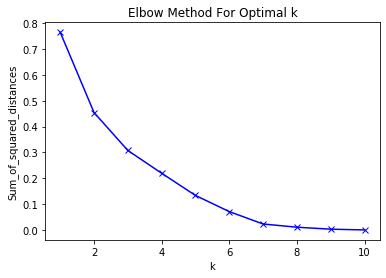

In [411]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [412]:
# set number of clusters
kclusters = 7

city_grouped_clustering = city_grouped

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 4, 0, 0, 2, 3, 0, 0, 6, 1], dtype=int32)

In [413]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = df2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('County'), on='County')

In [414]:
city_merged

ZipCode    County        City State   Latitude  Longitude  \
0      30101      Cobb     Acworth    GA  34.052285 -84.684830   
1      30102  Cherokee     Acworth    GA  34.097998 -84.618300   
3      30320    Fulton     Atlanta    GA  33.656824 -84.423648   
4      30004    Fulton  Alpharetta    GA  34.119177 -84.302920   
5      30005    Fulton  Alpharetta    GA  34.080035 -84.219290   
..       ...       ...         ...   ...        ...        ...   
276    30085    DeKalb      Tucker    GA  33.891251 -84.074560   
278    30290   Fayette      Tyrone    GA  33.480120 -84.587240   
279    30291    Fulton  Union City    GA  33.580878 -84.546110   
284    30187   Douglas     Winston    GA  33.670405 -84.838090   
285    30189  Cherokee   Woodstock    GA  34.117565 -84.571760   

     Cluster Labels 1st Most Common Venue        2nd Most Common Venue  \
0                 0   American Restaurant                         Park   
1                 5                  Pool                 Home Service   
3                 0   American Restaurant                        Hotel   
4                 0   American Restaurant                        Hotel   
5                 0   American Restaurant                        Hotel   
..              ...                   ...                          ...   
276               0           Coffee Shop               Sandwich Place   
278               3                  Park                  Auto Garage   
279               0   American Restaurant                        Hotel   
284               2           Gas Station  Eastern European Restaurant   
285               5                  Pool                 Home Service   

           3rd Most Common Venue 4th Most Common Venue  \
0                     Food Truck         Grocery Store   
1     Construction & Landscaping          Gourmet Shop   
3                    Coffee Shop                  Park   
4                    Coffee Shop                  Park   
5                    Coffee Shop                  Park   
..                           ...                   ...   
276          American Restaurant                  Park   
278       Thrift / Vintage Store           Pizza Place   
279                  Coffee Shop                  Park   
284  Professional & Other Places          Home Service   
285   Construction & Landscaping          Gourmet Shop   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                 Gift Shop                Garden        Ice Cream Shop   
1             Women's Store          Carpet Store     Health Food Store   
3            Clothing Store        Sandwich Place                   Gym   
4            Clothing Store        Sandwich Place                   Gym   
5            Clothing Store        Sandwich Place                   Gym   
..                      ...                   ...                   ...   
276          Cosmetics Shop    Mexican Restaurant        Ice Cream Shop   
278          Discount Store                   Spa              Pharmacy   
279          Clothing Store        Sandwich Place                   Gym   
284  Furniture / Home Store            Food Truck           Flea Market   
285           Women's Store          Carpet Store     Health Food Store   

    8th Most Common Venue 9th Most Common Venue      10th Most Common Venue  
0                    Pool           Coffee Shop                       Plaza  
1              Skate Park               Dog Run              Baseball Field  
3    Gym / Fitness Center         Grocery Store                 Pizza Place  
4    Gym / Fitness Center         Grocery Store                 Pizza Place  
5    Gym / Fitness Center         Grocery Store                 Pizza Place  
..                    ...                   ...                         ...  
276           Pizza Place        Clothing Store      Furniture / Home Store  
278                  Farm        Massage Studio  Construction & Landscaping  
279  Gym / Fitness Cent

In [415]:
city_merged = city_merged.dropna().drop_duplicates()

In [416]:
city_merged

ZipCode    County        City State   Latitude  Longitude  \
0      30101      Cobb     Acworth    GA  34.052285 -84.684830   
1      30102  Cherokee     Acworth    GA  34.097998 -84.618300   
3      30320    Fulton     Atlanta    GA  33.656824 -84.423648   
4      30004    Fulton  Alpharetta    GA  34.119177 -84.302920   
5      30005    Fulton  Alpharetta    GA  34.080035 -84.219290   
..       ...       ...         ...   ...        ...        ...   
276    30085    DeKalb      Tucker    GA  33.891251 -84.074560   
278    30290   Fayette      Tyrone    GA  33.480120 -84.587240   
279    30291    Fulton  Union City    GA  33.580878 -84.546110   
284    30187   Douglas     Winston    GA  33.670405 -84.838090   
285    30189  Cherokee   Woodstock    GA  34.117565 -84.571760   

     Cluster Labels 1st Most Common Venue        2nd Most Common Venue  \
0                 0   American Restaurant                         Park   
1                 5                  Pool                 Home Service   
3                 0   American Restaurant                        Hotel   
4                 0   American Restaurant                        Hotel   
5                 0   American Restaurant                        Hotel   
..              ...                   ...                          ...   
276               0           Coffee Shop               Sandwich Place   
278               3                  Park                  Auto Garage   
279               0   American Restaurant                        Hotel   
284               2           Gas Station  Eastern European Restaurant   
285               5                  Pool                 Home Service   

           3rd Most Common Venue 4th Most Common Venue  \
0                     Food Truck         Grocery Store   
1     Construction & Landscaping          Gourmet Shop   
3                    Coffee Shop                  Park   
4                    Coffee Shop                  Park   
5                    Coffee Shop                  Park   
..                           ...                   ...   
276          American Restaurant                  Park   
278       Thrift / Vintage Store           Pizza Place   
279                  Coffee Shop                  Park   
284  Professional & Other Places          Home Service   
285   Construction & Landscaping          Gourmet Shop   

      5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                 Gift Shop                Garden        Ice Cream Shop   
1             Women's Store          Carpet Store     Health Food Store   
3            Clothing Store        Sandwich Place                   Gym   
4            Clothing Store        Sandwich Place                   Gym   
5            Clothing Store        Sandwich Place                   Gym   
..                      ...                   ...                   ...   
276          Cosmetics Shop    Mexican Restaurant        Ice Cream Shop   
278          Discount Store                   Spa              Pharmacy   
279          Clothing Store        Sandwich Place                   Gym   
284  Furniture / Home Store            Food Truck           Flea Market   
285           Women's Store          Carpet Store     Health Food Store   

    8th Most Common Venue 9th Most Common Venue      10th Most Common Venue  
0                    Pool           Coffee Shop                       Plaza  
1              Skate Park               Dog Run              Baseball Field  
3    Gym / Fitness Center         Grocery Store                 Pizza Place  
4    Gym / Fitness Center         Grocery Store                 Pizza Place  
5    Gym / Fitness Center         Grocery Store                 Pizza Place  
..                    ...                   ...                         ...  
276           Pizza Place        Clothing Store      Furniture / Home Store  
278                  Farm        Massage Studio  Construction & Landscaping  
279  Gym / Fitness Cent

In [417]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#https://hub.arcgis.com/datasets/dc20713282734a73abe990995de40497_68
world_geo = r'Counties_Georgia.geojson'
map_clusters.choropleth(
    geo_data=world_geo)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []



for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['ZipCode'], city_merged['Cluster Labels']):        
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=.7).add_to(map_clusters)
       
map_clusters

#### Coffee shops (purple) are by far the most popular venue in Toronto. If you're making plans on a date, you will not run out of options on choosing a spot. Parks (orange) come in a far second. After a coffee date, a casual walk along the nearest park would be a pretty good idea.
------

In [385]:
neighborhoods_venues_sorted.sort_values("Cluster Labels", ascending = True).style.hide_index()

# Regression and Choropleth task

In [352]:
#https://github.com/maksimKorzh/one-time-scrapers/blob/master/scrapers/zillow/zillow_scraper.py
#Take off the comments if you want to run the scraper
class ZillowScraper:
    results = []

    headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'en-US,en;q=0.9',
        'cache-control': 'no-cache',
        'cookie': 'zguid=23|%2403435e76-0699-4a32-b86d-77d033c907ef; _ga=GA1.2.1271511001.1575011821; zjs_user_id=null; zjs_anonymous_id=%2203435e76-0699-4a32-b86d-77d033c907ef%22; _gcl_au=1.1.1333357279.1575011822; _pxvid=3cfcc163-1278-11ea-bff8-0242ac12000b; ki_r=; __gads=ID=84d8013cfac6df96:T=1575012041:S=ALNI_MaSvVNZsir2JXJ17pv54bjsPuyfcw; ki_s=199442%3A0.0.0.0.0%3B199444%3A0.0.0.0.2; zgsession=1|c0999376-b167-4a47-a1cd-0e456d882d4e; _gid=GA1.2.55965867.1578668946; JSESSIONID=87D0662A6BC141A73F0D12620788519C; KruxPixel=true; DoubleClickSession=true; KruxAddition=true; ki_t=1575011869563%3B1578669044158%3B1578669044158%3B2%3B10; _pxff_tm=1; _px3=2e6809e35ce7e076934ff998c2bdb8140e8b793b53e08a27c5da11f1b4760755:DFItCmrETuS2OQcztcFmt0FYPUn00ihAAue2ynQgbfSq6H+p2yP3Rl3aeyls3Unr1VRJSgcNue8Rr1SUq4P1jA==:1000:9ueZvAJ6v5y4ny7psGF25dK+d3GlytY2Bh+Xj9UUhC4DaioIZ+FMXPU0mOX+Qnghqut0jIT61gLecN4fyu6qXaPDlBX6YsZVbIry1YyBN/37l0Ri3JP+E0h+m+QEBB+bqb6MbE2HtgGBJRJAry8dgOKGM5JtBGdX+X/nuQX1xaw=; AWSALB=E6JYC43gXQRlE2jPT9e2vAQOYPvdHnccBlqi0mcXevYExTaHro0M+uo/Qxahi6JyLz9LpotY9eLtEbYrAOeQXcCm6UhjWnTopQHernmjlR/ibE6JmE8F6tReiBn4; search=6|1581261153229%7Crect%3D40.96202658306895%252C-73.55498286718745%252C40.4487909557045%252C-74.40093013281245%26rid%3D6181%26disp%3Dmap%26mdm%3Dauto%26p%3D3%26z%3D0%26lt%3Dfsbo%26pt%3Dpmf%252Cpf%26fs%3D1%26fr%3D0%26mmm%3D1%26rs%3D0%26ah%3D0%26singlestory%3D0%26housing-connector%3D0%26abo%3D0%26garage%3D0%26pool%3D0%26ac%3D0%26waterfront%3D0%26finished%3D0%26unfinished%3D0%26cityview%3D0%26mountainview%3D0%26parkview%3D0%26waterview%3D0%26hoadata%3D1%26zillow-owned%3D0%09%01%096181%09%09%09%090%09US_%09',
        'pragma': 'no-cache',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Ubuntu Chromium/75.0.3770.142 Chrome/75.0.3770.142 Safari/537.36'
    }

    def fetch(self, url, params):
        print('HTTP GET request to URL: %s' % url, end='')
        res = requests.get(url, params=params, headers=self.headers)
        print(' | Status code: %s' % res.status_code)
        
        return res
   
    def save_response(self, res):
        with open('res.html', 'w') as html_file:
            html_file.write(res)

    def load_response(self):
        html = ''
        
        with open('res.html', 'r') as html_file:
            for line in html_file:
                html += line
        
        return html
   
    def parse(self, html):
        content = BeautifulSoup(html, 'lxml')
        cards = content.findAll('article', {'class': 'list-card'})
        
        for card in cards:
            try:
                ba = card.find('ul', {'class': 'list-card-details'}).findAll('li')[1].text.split(' ')[0]
            except:
                ba = 'N/A'
            
            try:
                sqft = card.find('ul', {'class': 'list-card-details'}).findAll('li')[2].text.split(' ')[0]
            except:
                sqft = 'N/A'
            
            try:
                image = card.find('img')['src']
            except:
                image = 'N/A'

            self.results.append({
                'price': card.find('div', {'class': 'list-card-price'}).text,
                'address': card.find('address', {'class': 'list-card-addr'}).text,
                'bds': card.find('ul', {'class': 'list-card-details'}).findAll('li')[0].text.split(' ')[0],
                'ba': ba,
                'sqft': sqft,
                'image': image
            })
    
    def to_csv(self):
        with open('zillow_webscrape_test.csv', 'w') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=self.results[0].keys())
            writer.writeheader()
            
            for row in self.results:
                writer.writerow(row)
        
    def run(self):
        for page in range(1, 2):
            params = {
                'searchQueryState': '{"pagination":{"currentPage":%s}, "usersSearchTerm":"Rockdale County, GA","mapBounds":{"west":-84.30617756542966,"east":-83.79119343457029,"south":33.42598351319295,"north":33.88550871717414},"regionSelection":[{"regionId":2514,"regionType":4}],"isMapVisible":true,"filterState":{"sort":{"value":"globalrelevanceex"},"fsba":{"value":false},"fsbo":{"value":false},"nc":{"value":false},"fore":{"value":false},"cmsn":{"value":false},"auc":{"value":false},"pmf":{"value":false},"pf":{"value":false},"rs":{"value":true}},"isListVisible":true,"mapZoom":11}' % page
            }

            res = self.fetch('https://www.zillow.com/homes/Rockdale-County,-GA_rb/', params)
            self.parse(res.text)

        self.to_csv()
        

#if __name__ == '__main__':
#    scraper = ZillowScraper()
#    scraper.run()

HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https://www.zillow.com/homes/Rockdale-County,-GA_rb/ | Status code: 200
HTTP GET request to URL: https

In [455]:
zillow_fulton = pd.read_csv("zillow_fulton.csv")
zillow_dekalb = pd.read_csv("zillow_dekalb.csv")
zillow_gwinnett = pd.read_csv("zillow_gwinnett.csv")
zillow_fayette = pd.read_csv("zillow_fayette.csv")
zillow_rockdale = pd.read_csv("zillow_rockdale.csv")
zillow_cobb = pd.read_csv("zillow_cobb.csv")
zillow_clayton = pd.read_csv("zillow_clayton.csv")
zillow_douglas = pd.read_csv("zillow_douglas.csv")
zillow_cherokee = pd.read_csv("zillow_cherokee.csv")
zillow_henry = pd.read_csv("zillow_henry.csv")

In [456]:
os.chdir("/Users/jakesiu/Desktop/projects/Analyzing_House_Prices_and_Venues_in_Atlanta")
extension = 'csv'
all_filenames = [i for i in glob.glob('zillow_*.{}'.format(extension))]
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [457]:
zillow_atlanta = combined_csv
zillow_atlanta = zillow_atlanta.drop(['image'], axis=1)
zillow_atlanta = zillow_atlanta.drop_duplicates()
zillow_atlanta['price'] = zillow_atlanta['price'].str.replace(',', '')
zillow_atlanta['sqft'] = zillow_atlanta['sqft'].str.replace(',', '')
zillow_atlanta['bds'] = zillow_atlanta['bds'].str.replace(',', '')
zillow_atlanta['price'] = zillow_atlanta['price'].str.replace('$', '')
zillow_atlanta['ZipCode'] = zillow_atlanta['address'].str[-5:]
zillow_atlanta = zillow_atlanta.reset_index(drop=True)

In [458]:
def convert_price(value):
    if value.endswith("M"): 
        return float(value[:-1]) * 10**6
    else:
        return float(value)

zillow_atlanta['price'] = zillow_atlanta['price'].apply(convert_price)

In [459]:
zillow_atlanta['bds'] = zillow_atlanta['bds'].replace("Studio", "1")
zillow_atlanta['ba'] = zillow_atlanta['ba'].replace("Studio", "1")
zillow_atlanta['sqft'] = zillow_atlanta['sqft'].replace("Studio", "1")
zillow_atlanta = zillow_atlanta[~zillow_atlanta['bds'].isin(['--'])]
zillow_atlanta = zillow_atlanta[~zillow_atlanta['sqft'].isin(['--'])]
zillow_atlanta = zillow_atlanta[~zillow_atlanta['ba'].isin(['--'])]
zillow_atlanta = zillow_atlanta[~zillow_atlanta['bds'].isin(['N/A'])]
zillow_atlanta = zillow_atlanta[~zillow_atlanta['sqft'].isin(['N/A'])]
zillow_atlanta = zillow_atlanta[~zillow_atlanta['ba'].isin(['N/A'])]

In [460]:
zillow_atlanta['sqft'] = zillow_atlanta['sqft'].astype(float)
zillow_atlanta['bds'] = zillow_atlanta['bds'].astype(float)
zillow_atlanta['ba'] = zillow_atlanta['ba'].astype(float)
zillow_atlanta[zillow_atlanta['ZipCode'].apply(lambda x: str(x).isdigit())]
zillow_atlanta['ZipCode'] = pd.to_numeric(zillow_atlanta['ZipCode'], errors='coerce')
zillow_atlanta = zillow_atlanta.dropna(subset=['ZipCode'])
zillow_atlanta['ZipCode'] = zillow_atlanta['ZipCode'].astype(int)
zillow_atlanta = zillow_atlanta.dropna()
zillow_atlanta = zillow_atlanta[zillow_atlanta['sqft'] > 120]
zillow_atlanta = zillow_atlanta[zillow_atlanta['price'] > 30000]

In [461]:
zillow_atlanta.columns = ['price', 'address', 'beds', 'baths', 'square_feet', 'ZipCode']

In [462]:
zillow_atlanta = pd.merge(zillow_atlanta, zipcodes, on ='ZipCode', how ='inner').drop(['State', 'Latitude', 'Longitude'], axis=1)

In [463]:
zillow_atlanta

price                                        address  beds  baths  \
0     446500.0          273 Holland, Powder Springs, GA 30127   4.0    4.0   
1     230000.0      3630 Lavilla Dr, Powder Springs, GA 30127   4.0    3.0   
2     369500.0  1262 Clipper Bay Ct, Powder Springs, GA 30127   5.0    3.0   
3      78000.0      3528 Hopkins Ct, Powder Springs, GA 30127   3.0    3.0   
4     318000.0      3979 Lagrone St, Powder Springs, GA 30127   4.0    3.0   
...        ...                                            ...   ...    ...   
6331  127000.0    2389 Rolling Acres Dr SW, Conyers, GA 30094   4.0    2.0   
6332   66500.0               3144 Goode Rd, Conyers, GA 30094   2.0    2.0   
6333  270000.0              1405 Hadlow Ct, Conyers, GA 30094   5.0    4.0   
6334   95000.0        635 Lakeridge Cir SE, Conyers, GA 30094   3.0    3.0   
6335  156000.0      1500 Cherry Hill Rd SW, Conyers, GA 30094   4.0    3.0   

      square_feet  ZipCode    County            City  
0          2994.0    30127      Cobb  Powder Springs  
1          1752.0    30127      Cobb  Powder Springs  
2          3512.0    30127      Cobb  Powder Springs  
3          1364.0    30127      Cobb  Powder Springs  
4          2251.0    30127      Cobb  Powder Springs  
...           ...      ...       ...             ...  
6331       1872.0    30094  Rockdale         Conyers  
6332       1416.0    30094  Rockdale         Conyers  
6333       3153.0    30094  Rockdale         Conyers  
6334       1344.0    30094  Rockdale         Conyers  
6335       1588.0    30094  Rockdale         Conyers  

[6336 rows x 8 columns]

In [363]:
zillow_atlanta.to_csv("file_name.csv", index=False)

# Finding the median house prices by county:

In [464]:
median = zillow_atlanta.groupby(['County'], as_index=False, sort=False).median()
median = median.drop(['ZipCode'], axis=1).sort_values("price", ascending = False)
median

County     price  beds  baths  square_feet
7   Fayette  325000.0   4.0    3.0       2632.0
1    Fulton  320000.0   3.0    3.0       1930.0
0      Cobb  309900.0   4.0    3.0       2332.5
2  Cherokee  288490.0   4.0    3.0       2308.0
8  Gwinnett  273750.0   4.0    3.0       2414.0
4    DeKalb  255500.0   3.0    3.0       1890.0
3     Henry  225000.0   4.0    3.0       2325.5
6   Douglas  200000.0   3.0    3.0       1992.5
9  Rockdale  180000.0   3.0    3.0       1986.5
5   Clayton  150000.0   3.0    3.0       1642.5

In [365]:
#For those that want to see the mean
mean = zillow_atlanta.groupby(['County'], as_index=False, sort=False).mean()
mean.drop(['ZipCode'], axis=1).sort_values("price", ascending = False)

County          price      beds     baths  square_feet
1    Fulton  433001.112922  3.392317  3.061700  2397.515716
7   Fayette  364651.818325  3.886256  3.316746  2891.409163
0      Cobb  344727.050432  3.737752  3.168588  2594.190202
2  Cherokee  318702.630819  3.714286  3.097913  2543.743178
4    DeKalb  318155.785185  3.373333  2.800741  2058.648889
8  Gwinnett  299361.658076  3.864261  3.158935  2599.403780
9  Rockdale  255748.605839  3.585766  2.760949  2266.979927
3     Henry  240706.889685  3.828080  2.909026  2431.035817
6   Douglas  220349.492565  3.700743  2.827138  2234.923792
5   Clayton  169207.991770  3.504115  2.561728  1843.487654

In [451]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#https://hub.arcgis.com/datasets/dc20713282734a73abe990995de40497_68
world_geo = r'Counties_Georgia.geojson'
map_clusters.choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=median,
    columns=[ 'County','price'],
    key_on='feature.properties.NAME10',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median House Prices in Atlanta, Georgia (June 2020)')
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []



for venue1, venue2, venue3, venue4, county, lat, lon, poi, cluster in zip(city_merged['1st Most Common Venue'], city_merged['2nd Most Common Venue'], city_merged['3rd Most Common Venue'] , city_merged['4th Most Common Venue'], city_merged['County'], city_merged['Latitude'], city_merged['Longitude'], city_merged['ZipCode'], city_merged['Cluster Labels']):        
    label = folium.Popup(str(county) + ' County, ' + str(poi) + ' | Cluster ' + str(cluster)+': '+str(venue1)+'s, '+str(venue2)+'s, '+str(venue3)+'s, ' +str(venue4)+'s...', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=.7).add_to(map_clusters)
       
map_clusters

## Regression Analysis

In [724]:
df4 = zillow_atlanta
df4

price                                        address  beds  baths  \
0     446500.0          273 Holland, Powder Springs, GA 30127   4.0    4.0   
1     230000.0      3630 Lavilla Dr, Powder Springs, GA 30127   4.0    3.0   
2     369500.0  1262 Clipper Bay Ct, Powder Springs, GA 30127   5.0    3.0   
3      78000.0      3528 Hopkins Ct, Powder Springs, GA 30127   3.0    3.0   
4     318000.0      3979 Lagrone St, Powder Springs, GA 30127   4.0    3.0   
...        ...                                            ...   ...    ...   
6331  127000.0    2389 Rolling Acres Dr SW, Conyers, GA 30094   4.0    2.0   
6332   66500.0               3144 Goode Rd, Conyers, GA 30094   2.0    2.0   
6333  270000.0              1405 Hadlow Ct, Conyers, GA 30094   5.0    4.0   
6334   95000.0        635 Lakeridge Cir SE, Conyers, GA 30094   3.0    3.0   
6335  156000.0      1500 Cherry Hill Rd SW, Conyers, GA 30094   4.0    3.0   

      square_feet  ZipCode    County            City  
0          2994.0    30127      Cobb  Powder Springs  
1          1752.0    30127      Cobb  Powder Springs  
2          3512.0    30127      Cobb  Powder Springs  
3          1364.0    30127      Cobb  Powder Springs  
4          2251.0    30127      Cobb  Powder Springs  
...           ...      ...       ...             ...  
6331       1872.0    30094  Rockdale         Conyers  
6332       1416.0    30094  Rockdale         Conyers  
6333       3153.0    30094  Rockdale         Conyers  
6334       1344.0    30094  Rockdale         Conyers  
6335       1588.0    30094  Rockdale         Conyers  

[6336 rows x 8 columns]

In [725]:
df4 = df4.drop(['address', 'ZipCode', 'City'], axis=1)
df4

price  beds  baths  square_feet    County
0     446500.0   4.0    4.0       2994.0      Cobb
1     230000.0   4.0    3.0       1752.0      Cobb
2     369500.0   5.0    3.0       3512.0      Cobb
3      78000.0   3.0    3.0       1364.0      Cobb
4     318000.0   4.0    3.0       2251.0      Cobb
...        ...   ...    ...          ...       ...
6331  127000.0   4.0    2.0       1872.0  Rockdale
6332   66500.0   2.0    2.0       1416.0  Rockdale
6333  270000.0   5.0    4.0       3153.0  Rockdale
6334   95000.0   3.0    3.0       1344.0  Rockdale
6335  156000.0   4.0    3.0       1588.0  Rockdale

[6336 rows x 5 columns]

In [726]:
df4.describe()

price         beds        baths   square_feet
count  6.336000e+03  6336.000000  6336.000000   6336.000000
mean   3.059494e+05     3.651989     2.982481   2401.322759
std    2.435128e+05     1.058184     1.124602   1216.285407
min    3.100000e+04     1.000000     1.000000    220.000000
25%    1.829750e+05     3.000000     2.000000   1570.750000
50%    2.500000e+05     4.000000     3.000000   2150.500000
75%    3.580000e+05     4.000000     3.000000   2902.000000
max    7.300000e+06    25.000000    25.000000  21218.000000

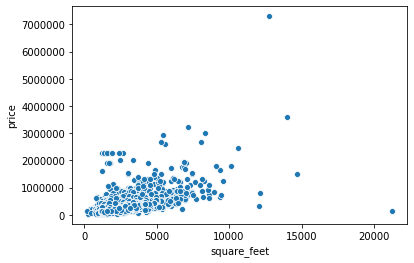

In [727]:
sns.scatterplot(x = 'square_feet', y = 'price', data = df4);

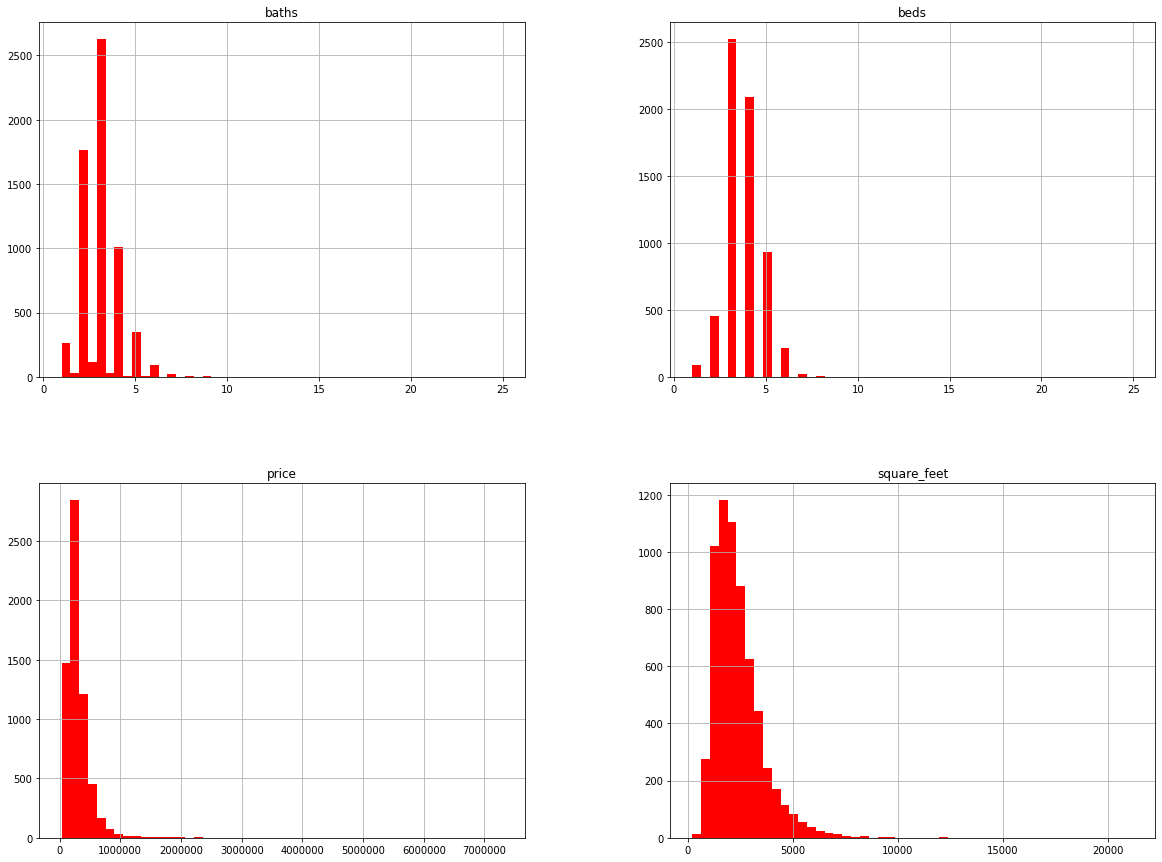

In [728]:
df4.hist(bins = 50, figsize = (20,15), color = 'r');

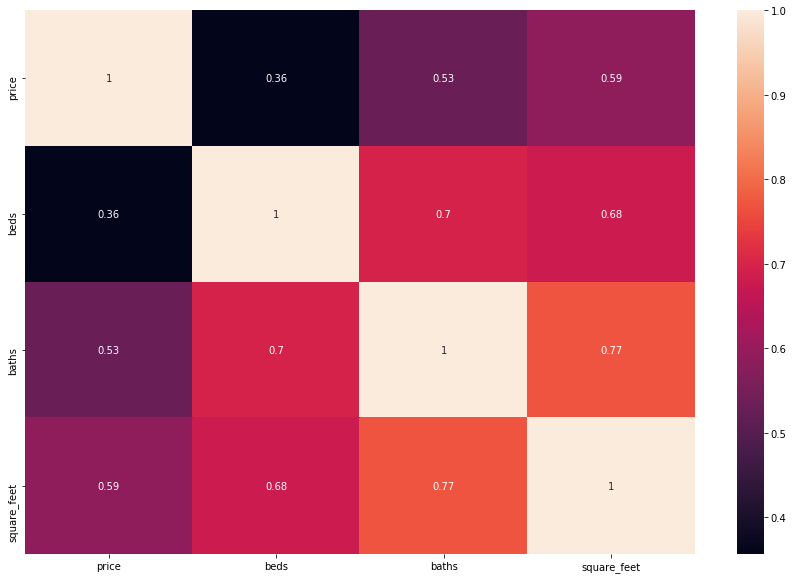

In [729]:
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df4.corr(), annot = True);

In [730]:
df4['price'] = np.log(df4['price'])
df4['baths'] = np.log(df4['baths'])
df4['square_feet'] = np.log(df4['square_feet'])
df4 = df4.rename(columns={"price": "log_price", "baths": "log_baths", "square_feet": "log_sqft"})
df4

log_price  beds  log_baths  log_sqft    County
0     13.009195   4.0   1.386294  8.004366      Cobb
1     12.345835   4.0   1.098612  7.468513      Cobb
2     12.819906   5.0   1.098612  8.163941      Cobb
3     11.264464   3.0   1.098612  7.218177      Cobb
4     12.669807   4.0   1.098612  7.719130      Cobb
...         ...   ...        ...       ...       ...
6331  11.751942   4.0   0.693147  7.534763  Rockdale
6332  11.104957   2.0   0.693147  7.255591  Rockdale
6333  12.506177   5.0   1.386294  8.056110  Rockdale
6334  11.461632   3.0   1.098612  7.203406  Rockdale
6335  11.957611   4.0   1.098612  7.370231  Rockdale

[6336 rows x 5 columns]

### Encoding Categorical Data

In [731]:
Feature = df4
Feature = pd.concat([Feature,pd.get_dummies(df4['County'])], axis=1)
Feature.drop(['Fulton', 'County'], axis = 1,inplace=True)
Feature.head()

log_price  beds  log_baths  log_sqft  Cherokee  Clayton  Cobb  DeKalb  \
0  13.009195   4.0   1.386294  8.004366         0        0     1       0   
1  12.345835   4.0   1.098612  7.468513         0        0     1       0   
2  12.819906   5.0   1.098612  8.163941         0        0     1       0   
3  11.264464   3.0   1.098612  7.218177         0        0     1       0   
4  12.669807   4.0   1.098612  7.719130         0        0     1       0   

   Douglas  Fayette  Gwinnett  Henry  Rockdale  
0        0        0         0      0         0  
1        0        0         0      0         0  
2        0        0         0      0         0  
3        0        0         0      0         0  
4        0        0         0      0         0

In [739]:
Feature

log_price  beds  log_baths  log_sqft  Cherokee  Clayton  Cobb  DeKalb  \
0     13.009195   4.0   1.386294  8.004366         0        0     1       0   
1     12.345835   4.0   1.098612  7.468513         0        0     1       0   
2     12.819906   5.0   1.098612  8.163941         0        0     1       0   
3     11.264464   3.0   1.098612  7.218177         0        0     1       0   
4     12.669807   4.0   1.098612  7.719130         0        0     1       0   
...         ...   ...        ...       ...       ...      ...   ...     ...   
6331  11.751942   4.0   0.693147  7.534763         0        0     0       0   
6332  11.104957   2.0   0.693147  7.255591         0        0     0       0   
6333  12.506177   5.0   1.386294  8.056110         0        0     0       0   
6334  11.461632   3.0   1.098612  7.203406         0        0     0       0   
6335  11.957611   4.0   1.098612  7.370231         0        0     0       0   

      Douglas  Fayette  Gwinnett  Henry  Rockdale  
0           0        0         0      0         0  
1           0        0         0      0         0  
2           0        0         0      0         0  
3           0        0         0      0         0  
4           0        0         0      0         0  
...       ...      ...       ...    ...       ...  
6331        0        0         0      0         1  
6332        0        0         0      0         1  
6333        0        0         0      0         1  
6334        0        0         0      0         1  
6335        0        0         0      0         1  

[6336 rows x 13 columns]

In [732]:
X = Feature.iloc[:, 1:].values
y = Feature.iloc[:, 0].values

In [733]:
X

array([[4.  , 1.39, 8.  , ..., 0.  , 0.  , 0.  ],
       [4.  , 1.1 , 7.47, ..., 0.  , 0.  , 0.  ],
       [5.  , 1.1 , 8.16, ..., 0.  , 0.  , 0.  ],
       ...,
       [5.  , 1.39, 8.06, ..., 0.  , 0.  , 1.  ],
       [3.  , 1.1 , 7.2 , ..., 0.  , 0.  , 1.  ],
       [4.  , 1.1 , 7.37, ..., 0.  , 0.  , 1.  ]])

### Normalizing

### Splitting the Data into the training and test set

In [734]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (5068, 12) (5068,)
Test set: (1268, 12) (1268,)


### Training the Multiple Regression model on the Training Set

In [735]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Predicting the Test Set Results

In [736]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)),1))

[[12.72 12.83]
 [12.48 12.63]
 [11.89 11.81]
 ...
 [12.28 11.94]
 [12.42 12.56]
 [12.46 12.35]]


In [737]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print('R2 =', r2) 

R2 = 0.6198551672737458


In [738]:
print(regressor.coef_)
print(regressor.intercept_)

[-0.02  0.16  0.73 -0.21 -0.63 -0.17 -0.15 -0.5  -0.22 -0.29 -0.47 -0.55]
7.069311282917502
